# Quora Question Pair Similarity 

In [129]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
# This package is used for finding longest common subsequence between two strings
# you can write your own dp code for this
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
# Import the Required lib packages for WORD-Cloud generation
# https://stackoverflow.com/questions/45625434/how-to-install-wordcloud-in-python3-6
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image

In [130]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

## Basic Feature Extraction (before cleaning)

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

# Random train test split( 70:30)

### We need to split the data before feature extraction because then there would be problem of data leakage otherwise.

In [185]:
data = pd.read_csv("train.csv")

In [186]:
data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [187]:
data.shape

(404290, 6)

In [188]:
data = data.dropna()

In [189]:
data.shape

(404287, 6)

In [190]:
data = data[data.question1 != df_train_advanced.iloc[12530]["question1"]]

In [191]:
data.shape

(404287, 6)

In [192]:
data.drop(data[data['question1'] == df_train_advanced.iloc[12530]["question1"]].index, inplace = True)

In [146]:
data.drop(data[data['question2'] == ""].index, inplace = True)

In [193]:
data.shape

(404287, 6)

In [66]:
type(data["is_duplicate"][5])

numpy.int64

In [67]:
y_true = data['is_duplicate']
data.drop(['is_duplicate'], axis=1, inplace=True)

In [68]:
data.shape

(404287, 5)

In [69]:
X_train,X_test, y_train, y_test = train_test_split(data, y_true, stratify=y_true, test_size=0.3)

In [70]:
X_train.shape

(283000, 5)

In [71]:
X_test.shape

(121287, 5)

In [72]:
X_train.head()

,id,qid1,qid2,question1,question2
307323,307323,430984,430985,Why haven't more car companies used CVCC techn...,Why haven't more car companies used CVCC techn...
34363,34363,14381,62970,Is it normal to fall out of love?,How do I fall out of love with someone?
98028,98028,87590,162974,Cash: How much USD can I legally carry on my p...,How much cash can you keep at home legally in ...
251666,251666,365834,365835,What were major contributions of the Assyrian?,What were the Assyrians' major contributions t...
152166,152166,239124,239125,"What is the coolest scientific ""experiment"" on...",What is the coolest science experiment to do a...


## Training Data : Applying basic feature extraction on the Training data

In [73]:
X_train['freq_qid1'] = X_train.groupby('qid1')['qid1'].transform('count') 
X_train['freq_qid2'] = X_train.groupby('qid2')['qid2'].transform('count')
X_train['q1len'] = X_train['question1'].str.len() 
X_train['q2len'] = X_train['question2'].str.len()
X_train['q1_n_words'] = X_train['question1'].apply(lambda row: len(row.split(" ")))
X_train['q2_n_words'] = X_train['question2'].apply(lambda row: len(row.split(" ")))

def normalized_word_Common(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)
X_train['word_Common'] = X_train.apply(normalized_word_Common, axis=1)

def normalized_word_Total(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * (len(w1) + len(w2))
X_train['word_Total'] = X_train.apply(normalized_word_Total, axis=1)

def normalized_word_share(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
X_train['word_share'] = X_train.apply(normalized_word_share, axis=1)

X_train['freq_q1+q2'] = X_train['freq_qid1']+X_train['freq_qid2']
X_train['freq_q1-q2'] = abs(X_train['freq_qid1']-X_train['freq_qid2'])

X_train.to_csv("df_fe_without_preprocessing_train_self.csv", index=False)

X_train.head()

,id,qid1,qid2,question1,question2,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
307323,307323,430984,430985,Why haven't more car companies used CVCC techn...,Why haven't more car companies used CVCC techn...,1,1,66,52,11,8,8.0,19.0,0.421053,2,0
34363,34363,14381,62970,Is it normal to fall out of love?,How do I fall out of love with someone?,5,6,33,39,8,9,3.0,17.0,0.176471,11,1
98028,98028,87590,162974,Cash: How much USD can I legally carry on my p...,How much cash can you keep at home legally in ...,3,1,91,52,19,11,6.0,30.0,0.200000,4,2
251666,251666,365834,365835,What were major contributions of the Assyrian?,What were the Assyrians' major contributions t...,1,1,46,61,7,8,5.0,15.0,0.333333,2,0
152166,152166,239124,239125,"What is the coolest scientific ""experiment"" on...",What is the coolest science experiment to do a...,2,1,70,53,12,10,7.0,22.0,0.318182,3,1


## Test Data : Applying basic feature extraction on the Test data

In [74]:
X_test['freq_qid1'] = X_test.groupby('qid1')['qid1'].transform('count') 
X_test['freq_qid2'] = X_test.groupby('qid2')['qid2'].transform('count')
X_test['q1len'] = X_test['question1'].str.len() 
X_test['q2len'] = X_test['question2'].str.len()
X_test['q1_n_words'] = X_test['question1'].apply(lambda row: len(row.split(" ")))
X_test['q2_n_words'] = X_test['question2'].apply(lambda row: len(row.split(" ")))

def normalized_word_Common(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)
X_test['word_Common'] = X_test.apply(normalized_word_Common, axis=1)

def normalized_word_Total(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * (len(w1) + len(w2))
X_test['word_Total'] = X_test.apply(normalized_word_Total, axis=1)

def normalized_word_share(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
X_test['word_share'] = X_test.apply(normalized_word_share, axis=1)

X_test['freq_q1+q2'] = X_test['freq_qid1']+X_test['freq_qid2']
X_test['freq_q1-q2'] = abs(X_test['freq_qid1']-X_test['freq_qid2'])

X_test.to_csv("df_fe_without_preprocessing_test_self.csv", index=False)

X_test.head()

,id,qid1,qid2,question1,question2,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
175087,175087,176590,269669,What are numbers? Do numbers exist? Where are ...,What are numbers? Do numbers exist?,1,1,91,35,16,6,6.0,17.0,0.352941,2,0
347894,347894,476403,476404,How is Victoria Beckham involved with Victoria...,"Why are Victoria Secret models so old, in comp...",1,1,56,77,8,13,1.0,20.0,0.050000,2,0
152745,152745,239913,239914,How genuine were the business leaders and cele...,Anyone has an idea about samsung J5570 tv mode...,1,1,112,136,18,24,0.0,40.0,0.000000,2,0
205968,205968,96410,44271,What kinds of thing can young people learn fro...,What could young people learn from old people?,2,3,59,46,11,8,7.0,19.0,0.368421,5,1
60393,60393,105617,90554,Where can I get real active Instagram followers?,What is the best way to get real Instagram fol...,2,3,48,53,8,10,4.0,18.0,0.222222,5,1


# Advanced feature extraction

In [75]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
# This package is used for finding longest common subsequence between two strings
# you can write your own dp code for this
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
# Import the Required lib packages for WORD-Cloud generation
# https://stackoverflow.com/questions/45625434/how-to-install-wordcloud-in-python3-6
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image

## Training data

In [76]:
#https://stackoverflow.com/questions/12468179/unicodedecodeerror-utf8-codec-cant-decode-byte-0x9c
if os.path.isfile('df_fe_without_preprocessing_train_self.csv'):
    df_train = pd.read_csv("df_fe_without_preprocessing_train_self.csv",encoding='latin-1')
    df_train = df_train.fillna('')
    df_train.head()
else:
    print("get df_fe_without_preprocessing_train.csv from drive or run the previous notebook")

In [77]:
df_train.head()

,id,qid1,qid2,question1,question2,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,307323,430984,430985,Why haven't more car companies used CVCC techn...,Why haven't more car companies used CVCC techn...,1,1,66,52,11,8,8.0,19.0,0.421053,2,0
1,34363,14381,62970,Is it normal to fall out of love?,How do I fall out of love with someone?,5,6,33,39,8,9,3.0,17.0,0.176471,11,1
2,98028,87590,162974,Cash: How much USD can I legally carry on my p...,How much cash can you keep at home legally in ...,3,1,91,52,19,11,6.0,30.0,0.200000,4,2
3,251666,365834,365835,What were major contributions of the Assyrian?,What were the Assyrians' major contributions t...,1,1,46,61,7,8,5.0,15.0,0.333333,2,0
4,152166,239124,239125,"What is the coolest scientific ""experiment"" on...",What is the coolest science experiment to do a...,2,1,70,53,12,10,7.0,22.0,0.318182,3,1


In [78]:
df_train.shape

(283000, 16)

## Test data

In [79]:
#https://stackoverflow.com/questions/12468179/unicodedecodeerror-utf8-codec-cant-decode-byte-0x9c
if os.path.isfile('df_fe_without_preprocessing_test_self.csv'):
    df_test = pd.read_csv("df_fe_without_preprocessing_test_self.csv",encoding='latin-1')
    df_test = df_test.fillna('')
    df_test.head()
else:
    print("get df_fe_without_preprocessing_train.csv from drive or run the previous notebook")

In [80]:
df_test.head()

,id,qid1,qid2,question1,question2,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,175087,176590,269669,What are numbers? Do numbers exist? Where are ...,What are numbers? Do numbers exist?,1,1,91,35,16,6,6.0,17.0,0.352941,2,0
1,347894,476403,476404,How is Victoria Beckham involved with Victoria...,"Why are Victoria Secret models so old, in comp...",1,1,56,77,8,13,1.0,20.0,0.050000,2,0
2,152745,239913,239914,How genuine were the business leaders and cele...,Anyone has an idea about samsung J5570 tv mode...,1,1,112,136,18,24,0.0,40.0,0.000000,2,0
3,205968,96410,44271,What kinds of thing can young people learn fro...,What could young people learn from old people?,2,3,59,46,11,8,7.0,19.0,0.368421,5,1
4,60393,105617,90554,Where can I get real active Instagram followers?,What is the best way to get real Instagram fol...,2,3,48,53,8,10,4.0,18.0,0.222222,5,1


In [81]:
df_test.shape

(121287, 16)

# Preprocessing of Text

- Preprocessing:
    - Removing html tags 
    - Removing Punctuations
    - Performing stemming
    - Removing Stopwords
    - Expanding contractions etc.

# Training data

In [82]:
# Function to Compute and get the features : With 2 parameters of Question 1 and Question 2

# To get the results in 4 decemal points
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x
    

## Advanced Feature Extraction (NLP and Fuzzy Features)

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if Last word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>





- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [83]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [84]:
if os.path.isfile('nlp_features_train_self.csv'):
    df_train_advanced = pd.read_csv("nlp_features_train_self.csv",encoding='latin-1')
    df_train_advanced.fillna(' ')
else:
    print("Extracting features for train:")
    #df_train = pd.read_csv("train.csv")
    df_train_advanced = extract_features(df_train)
    df_train_advanced.to_csv("nlp_features_train_self.csv", index=False)
df_train_advanced.head(2)

Extracting features for train:
token features...
fuzzy features..


,id,qid1,qid2,question1,question2,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,307323,430984,430985,why have not more car companies used cvcc tech...,why have not more car companies used cvcc tech...,1,1,66,52,11,...,0.749994,0.0,1.0,3.0,10.5,100,89,88,100,0.981481
1,34363,14381,62970,is it normal to fall out of love,how do i fall out of love with someone,5,6,33,39,8,...,0.444440,0.0,0.0,1.0,8.5,67,60,54,61,0.529412


# Test data

In [85]:
if os.path.isfile('nlp_features_test_self.csv'):
    df_test_advanced = pd.read_csv("nlp_features_test_self.csv",encoding='latin-1')
    df_test_advanced.fillna('')
else:
    print("Extracting features for train:")
    #df_train = pd.read_csv("train.csv")
    df_test_advanced = extract_features(df_test)
    df_test_advanced.to_csv("nlp_features_test_self.csv", index=False)
df_test_advanced.head(2)

Extracting features for train:
token features...
fuzzy features..


,id,qid1,qid2,question1,question2,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,175087,176590,269669,what are numbers do numbers exist where are ...,what are numbers do numbers exist,1,1,91,35,16,...,0.312498,1.0,1.0,10.0,11.0,100,55,55,100,0.972222
1,347894,476403,476404,how is victoria beckham involved with victoria...,why are victoria secret models so old in comp...,1,1,56,77,8,...,0.153845,0.0,0.0,4.0,11.0,60,64,50,35,0.169492


## Now we have two features in the form of text but for any machine learning model we need to pass data in the form of numerical data hence we will be converting it into the vectors form usinf tfidf vectorizer.

## Featurizing text data with tfidf vectors 

In [86]:
# avoid decoding problems

 
# encode questions to unicode
# https://stackoverflow.com/a/6812069
# ----------------- python 2 ---------------------
# df['question1'] = df['question1'].apply(lambda x: unicode(str(x),"utf-8"))
# df['question2'] = df['question2'].apply(lambda x: unicode(str(x),"utf-8"))
# ----------------- python 3 ---------------------

#train data
df_train_advanced['question1'] = df_train_advanced['question1'].apply(lambda x: str(x))
df_train_advanced['question2'] = df_train_advanced['question2'].apply(lambda x: str(x))

# test data 

df_test_advanced['question1'] = df_test_advanced['question1'].apply(lambda x: str(x))
df_test_advanced['question2'] = df_test_advanced['question2'].apply(lambda x: str(x))

In [87]:
from sklearn.feature_extraction.text import TfidfVectorizer

#training data

ques_set_1_train = list(df_train_advanced['question1'])
ques_set_2_train = list(df_train_advanced['question2'])

tfidf_ques_set_1_train = TfidfVectorizer(lowercase=False,)
tfidf_ques_set_2_train = TfidfVectorizer(lowercase=False,)

tfidf_ques_set_1_vectorized_train = tfidf_ques_set_1_train.fit_transform(ques_set_1_train)
tfidf_ques_set_2_vectorized_train = tfidf_ques_set_2_train.fit_transform(ques_set_2_train)

#test data 

ques_set_1_test = list(df_test_advanced['question1'])
ques_set_2_test = list(df_test_advanced['question2'])



tfidf_ques_set_1_vectorized_test = tfidf_ques_set_1_train.transform(ques_set_1_test)
tfidf_ques_set_2_vectorized_test = tfidf_ques_set_2_train.transform(ques_set_2_test)

print(tfidf_ques_set_1_vectorized_train.shape,y_train.shape)
print(tfidf_ques_set_2_vectorized_train.shape,y_train.shape)
print(tfidf_ques_set_1_vectorized_test.shape,y_test.shape)
print(tfidf_ques_set_2_vectorized_test.shape,y_test.shape)




(283000, 59181) (283000,)
(283000, 54624) (283000,)
(121287, 59181) (121287,)
(121287, 54624) (121287,)


### Dropping the unnecessary features now and creating the final data set for our model.

In [88]:
prefinal_data_train = df_train_advanced.drop(['qid1','qid2', 'id','question1','question2'],axis=1)

prefinal_data_test = df_test_advanced.drop(['qid1','qid2', 'id','question1','question2'],axis=1)

final_data_train = hstack((tfidf_ques_set_1_vectorized_train,tfidf_ques_set_2_vectorized_train,prefinal_data_train))

final_data_test = hstack((tfidf_ques_set_1_vectorized_test,tfidf_ques_set_2_vectorized_test,prefinal_data_test))


In [89]:
print(prefinal_data_train.shape)

(283000, 26)


In [90]:
print(final_data_train.shape)

(283000, 113831)


In [91]:
print(prefinal_data_test.shape)

(121287, 26)


In [92]:
print(final_data_test.shape)

(121287, 113831)


In [93]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

## Building a random model (Finding worst-case log-loss)

Log loss on Test Data using Random Model 0.8904065495035155


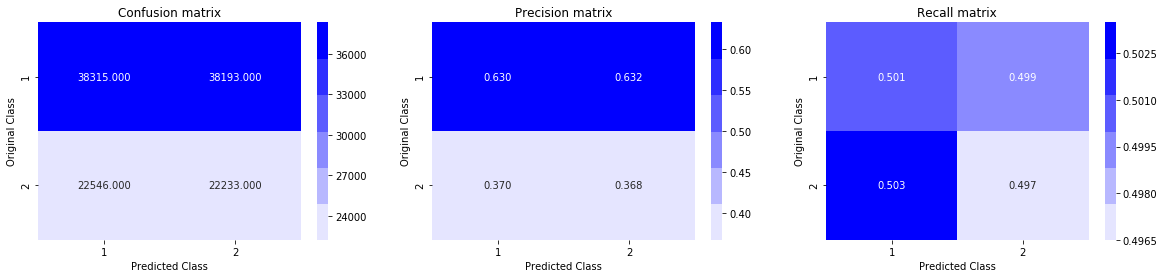

In [94]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data

test_len = len(y_test)
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

## Logistic Regression Model.

For values of alpha =  1e-05 The log loss is: 0.41650894648894
For values of alpha =  0.0001 The log loss is: 0.4242484952740375
For values of alpha =  0.001 The log loss is: 0.47048089305760604
For values of alpha =  0.01 The log loss is: 0.4982333828207982
For values of alpha =  0.1 The log loss is: 0.5148196423297065
For values of alpha =  1 The log loss is: 0.5436698742866424
For values of alpha =  10 The log loss is: 0.5776708988960267



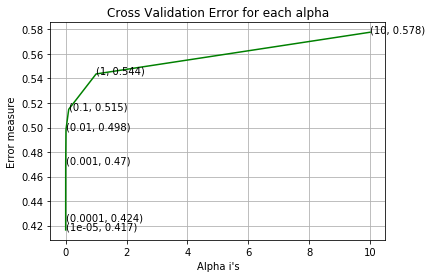

For values of best alpha =  1e-05 The train log loss is: 0.38041755433645974
For values of best alpha =  1e-05 The test log loss is: 0.41650894648894
Total number of data points : 121287


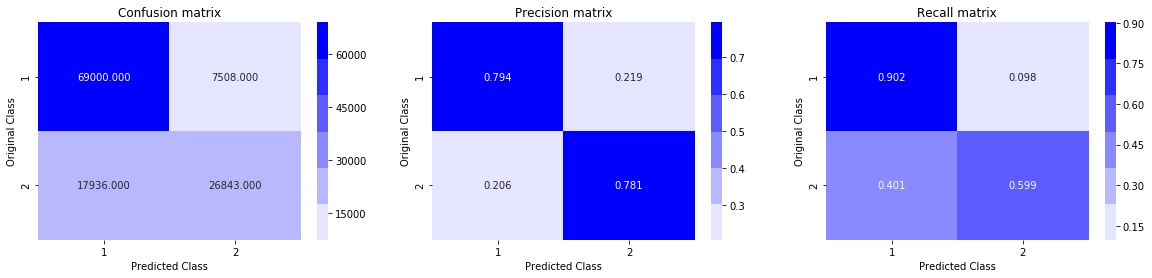

In [95]:

from tqdm import tqdm_notebook as tqdm

alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in tqdm(alpha):
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(final_data_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(final_data_train, y_train)
    predict_y = sig_clf.predict_proba(final_data_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in tqdm(enumerate(np.round(log_error_array,3))):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(final_data_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(final_data_train, y_train)

predict_y = sig_clf.predict_proba(final_data_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(final_data_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

### From above we get best value of alpha as 1e-05

## Trying Linear SVM model with hyperparameter tuning

For values of alpha =  1e-05 The log loss is: 0.46093289260970616
For values of alpha =  0.0001 The log loss is: 0.47986626864038295
For values of alpha =  0.001 The log loss is: 0.518334186158981
For values of alpha =  0.01 The log loss is: 0.5284372478286475
For values of alpha =  0.1 The log loss is: 0.5366349139309585
For values of alpha =  1 The log loss is: 0.6370270642507664
For values of alpha =  10 The log loss is: 0.6197422676238169



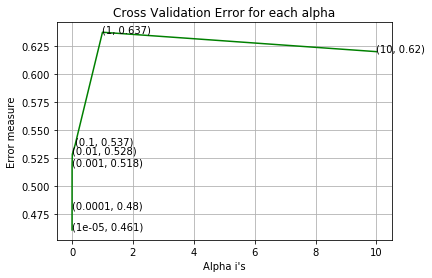

For values of best alpha =  1e-05 The train log loss is: 0.42927095736126397
For values of best alpha =  1e-05 The test log loss is: 0.46093289260970616
Total number of data points : 121287


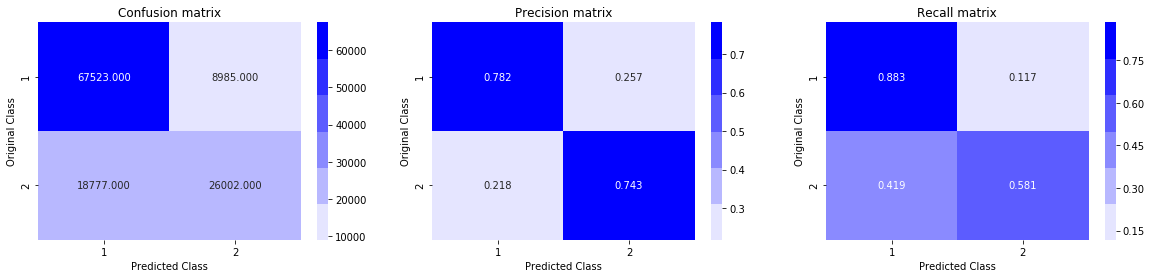

In [96]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in tqdm(alpha):
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(final_data_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(final_data_train, y_train)
    predict_y = sig_clf.predict_proba(final_data_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in tqdm(enumerate(np.round(log_error_array,3))):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(final_data_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(final_data_train, y_train)

predict_y = sig_clf.predict_proba(final_data_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(final_data_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

### From above we get best alpha as 1e-05

# Hyperparameter tune Xg Boost using RandomSearch to reduce the log-loss by 
# Featurizing text data with tfidf weighted word-vectors

#### We will be using spacy

In [97]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore")
import sys
import os 
import pandas as pd
import numpy as np
from tqdm import tqdm

# exctract word2vec vectors
# https://github.com/explosion/spaCy/issues/1721
# http://landinghub.visualstudio.com/visual-cpp-build-tools
import spacy



In [98]:
import en_core_web_sm

In [99]:
df_train_advanced

,id,qid1,qid2,question1,question2,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,307323,430984,430985,why have not more car companies used cvcc tech...,why have not more car companies used cvcc tech...,1,1,66,52,11,...,0.749994,0.0,1.0,3.0,10.5,100,89,88,100,0.981481
1,34363,14381,62970,is it normal to fall out of love,how do i fall out of love with someone,5,6,33,39,8,...,0.444440,0.0,0.0,1.0,8.5,67,60,54,61,0.529412
2,98028,87590,162974,cash how much usd can i legally carry on my p...,how much cash can you keep at home legally in ...,3,1,91,52,19,...,0.368419,0.0,0.0,8.0,15.0,76,56,43,56,0.169811
3,251666,365834,365835,what were major contributions of the assyrian,what were the assyrians major contributions t...,1,1,46,61,7,...,0.624992,0.0,1.0,1.0,7.5,85,81,67,67,0.446809
4,152166,239124,239125,what is the coolest scientific experiment on...,what is the coolest science experiment to do a...,2,1,70,53,12,...,0.666661,1.0,1.0,2.0,11.0,88,81,83,77,0.462963
5,365918,496052,496053,how do i write a thesis paper,how can i write a strong thesis paper,1,1,30,38,7,...,0.749991,1.0,1.0,1.0,7.5,95,82,82,77,0.451613
6,214664,93170,320316,will the big bang theory continue after season...,will season 10 of big bang theory be the final...,2,2,50,54,9,...,0.636358,0.0,1.0,2.0,10.0,85,73,67,66,0.333333
7,213344,306991,66064,what does an average japanese think about china,what do japanese people think about china,2,3,48,42,8,...,0.624992,1.0,1.0,1.0,7.5,86,77,77,75,0.465116
8,274006,392553,392554,how are servers connected to the internet,my internet explorer is unable to connect to t...,1,1,42,83,7,...,0.249998,0.0,0.0,9.0,11.5,63,59,15,31,0.232558
9,313902,285631,438528,which myers briggs personality type was sigmun...,which myers briggs types are the messiest,1,1,54,42,7,...,0.374995,0.0,1.0,1.0,7.5,68,60,60,64,0.441860


In [100]:
df_train_advanced.head()

,id,qid1,qid2,question1,question2,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,307323,430984,430985,why have not more car companies used cvcc tech...,why have not more car companies used cvcc tech...,1,1,66,52,11,...,0.749994,0.0,1.0,3.0,10.5,100,89,88,100,0.981481
1,34363,14381,62970,is it normal to fall out of love,how do i fall out of love with someone,5,6,33,39,8,...,0.444440,0.0,0.0,1.0,8.5,67,60,54,61,0.529412
2,98028,87590,162974,cash how much usd can i legally carry on my p...,how much cash can you keep at home legally in ...,3,1,91,52,19,...,0.368419,0.0,0.0,8.0,15.0,76,56,43,56,0.169811
3,251666,365834,365835,what were major contributions of the assyrian,what were the assyrians major contributions t...,1,1,46,61,7,...,0.624992,0.0,1.0,1.0,7.5,85,81,67,67,0.446809
4,152166,239124,239125,what is the coolest scientific experiment on...,what is the coolest science experiment to do a...,2,1,70,53,12,...,0.666661,1.0,1.0,2.0,11.0,88,81,83,77,0.462963


In [101]:
df_test_advanced.head()

,id,qid1,qid2,question1,question2,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,175087,176590,269669,what are numbers do numbers exist where are ...,what are numbers do numbers exist,1,1,91,35,16,...,0.312498,1.0,1.0,10.0,11.0,100,55,55,100,0.972222
1,347894,476403,476404,how is victoria beckham involved with victoria...,why are victoria secret models so old in comp...,1,1,56,77,8,...,0.153845,0.0,0.0,4.0,11.0,60,64,50,35,0.169492
2,152745,239913,239914,how genuine were the business leaders and cele...,anyone has an idea about samsung j5570 tv mode...,1,1,112,136,18,...,0.000000,0.0,0.0,6.0,21.0,21,20,24,25,0.035398
3,205968,96410,44271,what kinds of thing can young people learn fro...,what could young people learn from old people,2,3,59,46,11,...,0.545450,1.0,1.0,3.0,9.5,91,80,80,87,0.765957
4,60393,105617,90554,where can i get real active instagram followers,what is the best way to get real instagram fol...,2,3,48,53,8,...,0.399996,1.0,0.0,2.0,9.0,75,67,71,76,0.428571


In [109]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions_train = list(df_train_advanced['question1']) + list(df_train_advanced['question2'])

tfidf_train = TfidfVectorizer(lowercase=False,)
tfidf_train.fit_transform(questions_train)


# dict key:word and value:tf-idf score
word_to_tfidf_train = dict(zip(tfidf_train.get_feature_names(), tfidf_train.idf_))


In [110]:
#print(word_to_tfidf_train)

print(len(word_to_tfidf_train))

75241


In [111]:
questions_test = list(df_test_advanced['question1']) + list(df_test_advanced['question2'])

tfidf_train.fit_transform(questions_test)

word_to_tfidf_test = dict(zip(tfidf_train.get_feature_names(), tfidf_train.idf_))


In [113]:
print(len(word_to_tfidf_test))

51253


- After we find TF-IDF scores, we convert each question to a weighted average of word2vec vectors by these scores.
- here we use a pre-trained GLOVE model which comes free with "Spacy".  https://spacy.io/usage/vectors-similarity
- It is trained on Wikipedia and therefore, it is stronger in terms of word semantics. 

## Training data

In [118]:
nlp = en_core_web_sm.load()
b = nlp("  why is windows 8 1 better than windows 8")
print(b[0])
print(b[0].vector)
print(len(b[1].vector))

  
[-0.9525662  -2.5002687  -4.4875417  -1.9638036  -1.6534147  -0.73024225
  4.281701    2.6608083  -0.9626423   3.2770376   3.1853538   0.14069447
 -1.450932   -4.0068707  -1.8085659   1.0211391   2.7586927   0.1162557
 -1.6390661   1.3143853  -0.8224641  -1.1862966  -2.4527912   7.3386655
 -1.9965899   0.27951044 -1.9422514  -3.2176871   4.68439     9.470723
  3.9927957  -1.8580525  -2.2689922  -0.39820725 -0.32314092  0.24061304
  1.1145824   1.3387492   0.07262322 -0.03293261 -0.39051062 -0.21403557
 -2.4694285   1.2359965  -0.74682236 -3.722413    1.0628393   0.05004019
 -0.38331282 -0.8995835  -4.4561625   0.3103042  -1.8295093  -4.13437
  0.99405587  0.6113877  -0.55875224  1.5417417  -5.6916676   1.1636375
 -0.76107544  0.03636897 -0.0314011   0.84815174 -0.7989348   0.20037794
  3.8253684  -4.6280785  -2.6242979  -0.88505507  0.9127014   0.4201569
  0.9240186   3.270088    0.3128389  -1.1580241  -1.5440085  -1.7788529
  4.42894    -3.5577254   0.43271866  1.8254749  -3.902329

In [113]:
for i in list(df_train_advanced['question1'][13225:13235]):
    print(i)
    print(type(i))

which are some of the best pictures that make us proud as indians 
<class 'str'>
how much is the living cost in jakarta  indonesia 
<class 'str'>
how do you delete a question on quora 
<class 'str'>
why nobody answer my questions in quora 
<class 'str'>
is it easy to learn java 
<class 'str'>
why is windows 8 1 better than windows 8 
<class 'str'>
how can i get an internship in a paris museum 
<class 'str'>
what online payment methods are most popular in yemen 
<class 'str'>
how do i get employed with quora 
<class 'str'>
are we being slaves to money 
<class 'str'>


In [150]:
df_train_advanced['question1'][12514:12518]

12514                            which are the best novel 
12515    which are the best countries for civil enginee...
12516    what is the reaction between copper nitrate an...
12517    do men always initiate conversation if they li...
Name: question1, dtype: object

In [148]:
type(list(df_train_advanced['question1'][12514:12518]))

list

In [205]:
# question 1 column train data

from tqdm import tqdm_notebook as tqdm
# en_vectors_web_lg, which includes over 1 million unique vectors.
#nlp = spacy.load('en_core_web_sm')

nlp = en_core_web_sm.load()

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(df_train_advanced['question1'])):
    doc1 = nlp(qu1)
    # 384 is the number of dimensions of vectors 
    if len(doc1) == 0:
        mean_vec1 = np.zeros([1, len(nlp(" ").vector)])
    else:
        mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word_to_tfidf_train[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
df_train_advanced['q1_feats_m'] = list(vecs1)   
    


In [208]:
# question 2 column train data

vecs2 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu2 in tqdm(list(df_train_advanced['question2'])):
    doc1 = nlp(qu2) 
    # 384 is the number of dimensions of vectors 
    if len(doc1) == 0:
        mean_vec2 = np.zeros([1, len(nlp(" ").vector)])
    else:
        mean_vec2 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec2 = word1.vector
        # fetch df score
        try:
            idf = word_to_tfidf_train[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
df_train_advanced['q2_feats_m'] = list(vecs2)



In [209]:
# question 1 column test data


from tqdm import tqdm_notebook as tqdm
# en_vectors_web_lg, which includes over 1 million unique vectors.
#nlp = spacy.load('en_core_web_sm')

nlp = en_core_web_sm.load()

vecs3 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(df_test_advanced['question1'])):
    doc1 = nlp(qu1)
    # 384 is the number of dimensions of vectors 
    if len(doc1) == 0:
        mean_vec3 = np.zeros([1, len(nlp(" ").vector)])
    else:
        mean_vec3 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec3 = word1.vector
        # fetch df score
        try:
            idf = word_to_tfidf_train[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec3 += vec3 * idf
    mean_vec3 = mean_vec3.mean(axis=0)
    vecs3.append(mean_vec3)
df_test_advanced['q1_feats_m'] = list(vecs3)   
    


In [210]:
# question 2 column test data


from tqdm import tqdm_notebook as tqdm
# en_vectors_web_lg, which includes over 1 million unique vectors.
#nlp = spacy.load('en_core_web_sm')

nlp = en_core_web_sm.load()

vecs4 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(df_test_advanced['question2'])):
    doc1 = nlp(qu1)
    # 384 is the number of dimensions of vectors 
    if len(doc1) == 0:
        mean_vec4 = np.zeros([1, len(nlp(" ").vector)])
    else:
        mean_vec4 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec4 = word1.vector
        # fetch df score
        try:
            idf = word_to_tfidf_train[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec4 += vec4 * idf
    mean_vec4 = mean_vec4.mean(axis=0)
    vecs4.append(mean_vec4)
df_test_advanced['q2_feats_m'] = list(vecs4)   
    


In [211]:
df_test_advanced.shape

(121287, 33)

In [212]:
df_train_advanced.shape

(283000, 33)

In [213]:
len(df_test_advanced["q2_feats_m"])

121287

In [214]:
len(df_test_advanced["q1_feats_m"])

121287

In [215]:
len(df_train_advanced["q2_feats_m"])

283000

In [216]:
len(df_train_advanced["q1_feats_m"])

283000

In [217]:
df_train_advanced.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'freq_qid1',
       'freq_qid2', 'q1len', 'q2len', 'q1_n_words', 'q2_n_words',
       'word_Common', 'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2',
       'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio', 'q1_feats_m',
       'q2_feats_m'],
      dtype='object')

In [218]:
len(df_train_advanced["q1_feats_m"][5])

96

In [219]:
len(df_test_advanced["q2_feats_m"][50])

96

In [220]:
df_train_advanced.head(2)

,id,qid1,qid2,question1,question2,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,...,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,q1_feats_m,q2_feats_m
0,307323,430984,430985,why have not more car companies used cvcc tech...,why have not more car companies used cvcc tech...,1,1,66,52,11,...,1.0,3.0,10.5,100,89,88,100,0.981481,"[140.57885539531708, 11.261789426207542, -65.3...","[152.301274061203, -18.358907595276833, -61.80..."
1,34363,14381,62970,is it normal to fall out of love,how do i fall out of love with someone,5,6,33,39,8,...,0.0,1.0,8.5,67,60,54,61,0.529412,"[-10.141340017318726, -20.471665859222412, -26...","[45.4298677444458, -31.61658227443695, -29.268..."


In [223]:
i = 5
b = "x" + str(i)
print(b)

x5


### Now we need to convert the values in the q1_feats_m and q2_feats_m in the form of features and then our model will be ready 

## Every q2_feats_m and q1_feats_m value is a vector of 96 dimensions hence we will need 96 column names firstly hence lets create the column names first.

In [227]:
question_1_column_names = []
question_2_column_names = []

for i in range(0,96):
    question_1_column_names.append("que1_" + str(i))
    question_2_column_names.append("que2_" + str(i))
    
print(question_1_column_names)

print(question_2_column_names)
    


['que1_0', 'que1_1', 'que1_2', 'que1_3', 'que1_4', 'que1_5', 'que1_6', 'que1_7', 'que1_8', 'que1_9', 'que1_10', 'que1_11', 'que1_12', 'que1_13', 'que1_14', 'que1_15', 'que1_16', 'que1_17', 'que1_18', 'que1_19', 'que1_20', 'que1_21', 'que1_22', 'que1_23', 'que1_24', 'que1_25', 'que1_26', 'que1_27', 'que1_28', 'que1_29', 'que1_30', 'que1_31', 'que1_32', 'que1_33', 'que1_34', 'que1_35', 'que1_36', 'que1_37', 'que1_38', 'que1_39', 'que1_40', 'que1_41', 'que1_42', 'que1_43', 'que1_44', 'que1_45', 'que1_46', 'que1_47', 'que1_48', 'que1_49', 'que1_50', 'que1_51', 'que1_52', 'que1_53', 'que1_54', 'que1_55', 'que1_56', 'que1_57', 'que1_58', 'que1_59', 'que1_60', 'que1_61', 'que1_62', 'que1_63', 'que1_64', 'que1_65', 'que1_66', 'que1_67', 'que1_68', 'que1_69', 'que1_70', 'que1_71', 'que1_72', 'que1_73', 'que1_74', 'que1_75', 'que1_76', 'que1_77', 'que1_78', 'que1_79', 'que1_80', 'que1_81', 'que1_82', 'que1_83', 'que1_84', 'que1_85', 'que1_86', 'que1_87', 'que1_88', 'que1_89', 'que1_90', 'que1_91

In [225]:
# now let us get the values of q1_feats_m and q2_feats_m out from their columns 
# refer --> https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html

que1_values_train = pd.DataFrame(df_train_advanced.q1_feats_m.values.tolist(), index= df_train_advanced.index)

que2_values_train = pd.DataFrame(df_train_advanced.q2_feats_m.values.tolist(), index= df_train_advanced.index)

que1_values_test = pd.DataFrame(df_test_advanced.q1_feats_m.values.tolist(), index= df_test_advanced.index)

que2_values_test = pd.DataFrame(df_test_advanced.q2_feats_m.values.tolist(), index= df_test_advanced.index)

In [228]:
# let us give the column names for the new dataframe to be formed 

# refer ---> https://datascience.stackexchange.com/questions/45314/dataframe-has-no-column-names-how-to-add-a-header

que1_values_train.columns = question_1_column_names

que2_values_train.columns = question_2_column_names

que1_values_test.columns = question_1_column_names

que2_values_test.columns = question_2_column_names






In [229]:
# now let us merge the training dataframes first created above 

data_training  = que1_values_train.join(que2_values_train,how ='outer')

data_testing = que1_values_test.join(que2_values_test,how="outer")

In [231]:
data_training.shape

(283000, 192)

In [232]:
data_testing.shape

(121287, 192)

## Now as our data is ready let us apply XGBOOST implementation of GBDT on it along with hyperparameters using GridSearch and then finding the best values of hyperparameters.

In [234]:
import xgboost as xgb
clf_xgb = xgb.XGBClassifier(objective= 'binary:logistic',eval_metric='logloss')

# refer ---> https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

tuned_parameters = {'max_depth' : [2,4,5,7],'n_estimators' : [100,250,400,550,700,800],'learning_rate' : [0.001,0.1,1]}


grid_classifier = GridSearchCV(clf_xgb, tuned_parameters,verbose = 10,n_jobs=-1, cv=2,scoring='neg_log_loss')


grid_classifier.fit(data_training,y_train)


best_params = grid_classifier.best_params_
best_value =  grid_classifier.best_score_

print("Best score received = ", best_value,"  ","best parameters were " , best_params)




Fitting 2 folds for each of 72 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed: 38.5min
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed: 68.3min
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed: 102.0min
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed: 150.3min
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed: 210.3min
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed: 239.5min
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed: 293.3min
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed: 358.2min
[Parallel(n_jobs=-1)]: Done 101 tasks      | elapsed: 433.5min
[Parallel(n_jobs=-1)]: Done 116 tasks      | elapsed: 481.8min
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed: 566.2min
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed: 647.6min finished


Best score received =  -0.4651896535321332    best parameters were  {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 800}


### Now from above we have received the value of best parameters hence let's apply XGBoost using the best parameters

In [235]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.1
params['max_depth'] = 7
params['n_estimators'] = 800

d_train = xgb.DMatrix(data_training, label=y_train)
d_test = xgb.DMatrix(data_testing, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(data_training,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y,eps=1e-15))

[0]	train-logloss:0.677234	valid-logloss:0.678349
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.601503	valid-logloss:0.609432
[20]	train-logloss:0.574238	valid-logloss:0.586508
[30]	train-logloss:0.55653	valid-logloss:0.572627
[40]	train-logloss:0.543201	valid-logloss:0.562906
[50]	train-logloss:0.53299	valid-logloss:0.555764
[60]	train-logloss:0.523262	valid-logloss:0.549455
[70]	train-logloss:0.515069	valid-logloss:0.544095
[80]	train-logloss:0.508041	valid-logloss:0.539736
[90]	train-logloss:0.501764	valid-logloss:0.536033
[100]	train-logloss:0.495252	valid-logloss:0.532235
[110]	train-logloss:0.488166	valid-logloss:0.528385
[120]	train-logloss:0.482994	valid-logloss:0.525676
[130]	train-logloss:0.477306	valid-logloss:0.522619
[140]	train-logloss:0.472524	valid-logloss:0.520162
[150]	train-logloss:0.46797	valid-logloss:0.517961
[160]	train-logloss:0.462941	va

# Conclusions and Summary 

In [236]:
from prettytable import PrettyTable

x = PrettyTable(["Model", "Vectorizer" ,"Hyperparameter Tuning","Train-logloss", "Test-log loss"])

x.add_row(["Logistic Regression" ,"TD_IDF ","yes", 0.38041755, 0.4165089])

x.add_row(["Linear SVM" ,"TD_IDF ","yes", 0.4292709, 0.4292709])

x.add_row(["XG Boost implementation of GBDT" ,"TD_IDF Weighted W2V ","yes", 0.3780, 0.4803919])

print(x)




+---------------------------------+----------------------+-----------------------+---------------+---------------+
|              Model              |      Vectorizer      | Hyperparameter Tuning | Train-logloss | Test-log loss |
+---------------------------------+----------------------+-----------------------+---------------+---------------+
|       Logistic Regression       |       TD_IDF         |          yes          |   0.38041755  |   0.4165089   |
|            Linear SVM           |       TD_IDF         |          yes          |   0.4292709   |   0.4292709   |
| XG Boost implementation of GBDT | TD_IDF Weighted W2V  |          yes          |     0.378     |   0.4803919   |
+---------------------------------+----------------------+-----------------------+---------------+---------------+
